In [1]:
import torch
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaModel



c:\Users\piotr\Desktop\WB2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = pd.read_csv('data/embeddings_train_x.csv')
y = pd.read_csv('data/train.csv')['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)



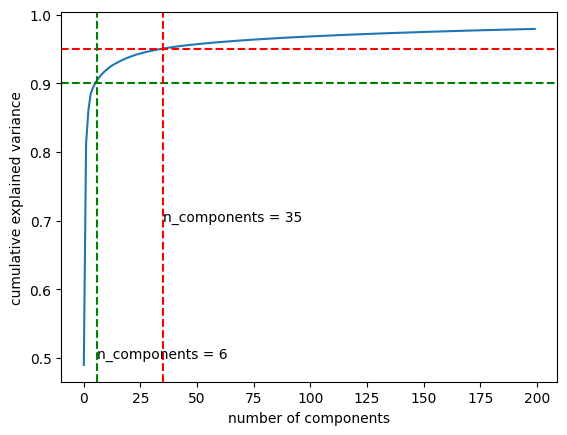

In [4]:
# generate plot of variance explained vs number of components
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def plot_variance_explained_vs_components(X, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    # add a horizontal line at 95% and 90%
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.axhline(y=0.90, color='g', linestyle='--')
    # calculate the number of components that explain 95% and 90% of the variance
    n_components_95 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
    n_components_90 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]
    plt.axvline(x=n_components_95, color='r', linestyle='--')
    plt.axvline(x=n_components_90, color='g', linestyle='--')
    # mark at x axis the number of components that explain 95% and 90% of the variance
    plt.text(n_components_95, 0.7, f'n_components = {n_components_95}')
    plt.text(n_components_90, 0.5, f'n_components = {n_components_90}')
    plt.show()

plot_variance_explained_vs_components(X_train, 200)

In [5]:
pca = PCA(n_components=35)
X_train_pca = pca.fit_transform(X_train)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(pca.transform(X_val))
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.33663366336633666
[[155 137 144]
 [145 126 118]
 [148 112 127]]
              precision    recall  f1-score   support

           0       0.35      0.36      0.35       436
           1       0.34      0.32      0.33       389
           2       0.33      0.33      0.33       387

    accuracy                           0.34      1212
   macro avg       0.34      0.34      0.34      1212
weighted avg       0.34      0.34      0.34      1212



In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best Parameters: {grid_search.best_params_}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [14]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=5)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(pca.transform(X_val))
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.3721122112211221
[[180 110 146]
 [137 134 118]
 [151  99 137]]
              precision    recall  f1-score   support

           0       0.38      0.41      0.40       436
           1       0.39      0.34      0.37       389
           2       0.34      0.35      0.35       387

    accuracy                           0.37      1212
   macro avg       0.37      0.37      0.37      1212
weighted avg       0.37      0.37      0.37      1212



In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

# Initialize the model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

# Add second hidden layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(units=y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


c:\Users\piotr\Desktop\WB2\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3314 - loss: 1.2217 - val_accuracy: 0.3336 - val_loss: 1.0974
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3533 - loss: 1.0969 - val_accuracy: 0.3419 - val_loss: 1.0955
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3505 - loss: 1.0945 - val_accuracy: 0.3538 - val_loss: 1.0944
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3558 - loss: 1.0917 - val_accuracy: 0.3593 - val_loss: 1.0935
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3503 - loss: 1.0936 - val_accuracy: 0.3611 - val_loss: 1.0924
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3573 - loss: 1.0904 - val_accuracy: 0.3731 - val_loss: 1.0906
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3670 - loss: 1.0887 - val_accuracy: 0.3859 - val_loss: 1.0858
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3717 - loss: 1.0884 - val_accuracy: 0.4115 - val_

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Test accuracy: {test_accuracy}')

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_val_encoded, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print(f'Classification Report:\n{class_report}')


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4730 - loss: 1.0265
Test accuracy: 0.4587458670139313
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.45874587458745875
Confusion Matrix:
[[315 103  18]
 [242 128  19]
 [201  73 113]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.72      0.53       436
           1       0.42      0.33      0.37       389
           2       0.75      0.29      0.42       387

    accuracy                           0.46      1212
   macro avg       0.53      0.45      0.44      1212
weighted avg       0.53      0.46      0.44      1212



In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from itertools import product


In [10]:
def create_and_train_model(X_train, y_train, X_val, y_val, optimizer='adam', init='glorot_uniform', epochs=50, batch_size=32):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=init, input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=init))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=init))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return model, val_accuracy


In [11]:
y = pd.get_dummies(y).values

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create a representative sample of the data (e.g., 20% of the dataset)
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.8, random_state=42)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [12]:
# Define the hyperparameters to search over
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150],
    'optimizer': ['SGD', 'Adam'],
    'init': ['glorot_uniform', 'normal']
}

# Create combinations of hyperparameters
combinations = list(product(param_grid['batch_size'], param_grid['epochs'], param_grid['optimizer'], param_grid['init']))

best_accuracy = 0
best_params = None
best_model = None

for batch_size, epochs, optimizer, init in combinations:
    print(f"Training with batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}, init={init}")
    model, val_accuracy = create_and_train_model(X_train_sample, y_train_sample, X_test_sample, y_test_sample, optimizer=optimizer, init=init, epochs=epochs, batch_size=batch_size)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = (batch_size, epochs, optimizer, init)
        best_model = model

print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: batch_size={best_params[0]}, epochs={best_params[1]}, optimizer={best_params[2]}, init={best_params[3]}")


Training with batch_size=16, epochs=50, optimizer=SGD, init=glorot_uniform


c:\Users\piotr\Desktop\WB2\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with batch_size=16, epochs=50, optimizer=SGD, init=normal
Training with batch_size=16, epochs=50, optimizer=Adam, init=glorot_uniform
Training with batch_size=16, epochs=50, optimizer=Adam, init=normal
Training with batch_size=16, epochs=100, optimizer=SGD, init=glorot_uniform
Training with batch_size=16, epochs=100, optimizer=SGD, init=normal
Training with batch_size=16, epochs=100, optimizer=Adam, init=glorot_uniform
Training with batch_size=16, epochs=100, optimizer=Adam, init=normal
Training with batch_size=16, epochs=150, optimizer=SGD, init=glorot_uniform
Training with batch_size=16, epochs=150, optimizer=SGD, init=normal
Training with batch_size=16, epochs=150, optimizer=Adam, init=glorot_uniform
Training with batch_size=16, epochs=150, optimizer=Adam, init=normal
Training with batch_size=32, epochs=50, optimizer=SGD, init=glorot_uniform
Training with batch_size=32, epochs=50, optimizer=SGD, init=normal
Training with batch_size=32, epochs=50, optimizer=Adam, init=glorot

In [13]:
best_batch_size, best_epochs, best_optimizer, best_init = best_params

final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=best_init, input_shape=(X.shape[1],)))
final_model.add(tf.keras.layers.Dropout(0.3))
final_model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=best_init))
final_model.add(tf.keras.layers.Dropout(0.3))
final_model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=best_init))
final_model.add(tf.keras.layers.Dropout(0.3))
final_model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))
final_model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.fit(X, y, epochs=best_epochs, batch_size=best_batch_size, verbose=1)


Epoch 1/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3494 - loss: 1.1156
Epoch 2/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3799 - loss: 1.0894
Epoch 3/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4322 - loss: 1.0575
Epoch 4/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4685 - loss: 1.0246
Epoch 5/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4846 - loss: 1.0050
Epoch 6/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4958 - loss: 0.9841
Epoch 7/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5064 - loss: 0.9776
Epoch 8/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5249 - loss: 0.9612
Epoch 9/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5410 - loss: 0.9413
Epoch 10/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5481 - loss: 0.9182
Epoch 11/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5499 - loss: 0.9249
Epoch 12/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [14]:
# Evaluate the model on a hold-out test set or cross-validation
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)
test_loss, test_accuracy = final_model.evaluate(X_test_full, y_test_full)
print(f'Test accuracy: {test_accuracy}')

# Make predictions
y_pred = final_model.predict(X_test_full)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_full, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print(f'Classification Report:\n{class_report}')


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8763 - loss: 0.3350 
Test accuracy: 0.8762376308441162
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8762376237623762
Confusion Matrix:
[[829   8  14]
 [136 615  22]
 [ 95  25 680]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       851
           1       0.95      0.80      0.87       773
           2       0.95      0.85      0.90       800

    accuracy                           0.88      2424
   macro avg       0.89      0.87      0.88      2424
weighted avg       0.89      0.88      0.88      2424



In [18]:
X_train_full.shape

(9696, 1536)

In [15]:
#  save final model
final_model.save('final_model.h5')
# load final model
# loaded_model = tf.keras.models.load_model('final_model.h5')

In [25]:
test = pd.read_csv('data/embeddings_test_x.csv')
test_df = pd.read_csv('data/test.csv')
test_df

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [23]:
test.shape

(5195, 1536)

In [24]:
test = scaler.transform(test)
y_pred = final_model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


In [27]:
y_pred_classes
results_df = pd.DataFrame({
    'id': test_df['id'],
    'prediction': y_pred_classes
})
results_df.to_csv('results/nn_predicted_results.csv', index=False)

